In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib as mpl
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
import matplotlib.transforms as transforms
import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline


plt.style.use('seaborn-v0_8-ticks')

mpl_config = pd.read_csv('../mpl_config.csv').to_dict(orient='records')[0]

mpl.rcParams.update(mpl_config)

In [3]:
def standardize(M) :   
    """ Standardization by column for 2D matrices """
    
    M_copy = np.copy(M)
    M_copy = M_copy.astype(float)
    for j in range(np.shape(M)[1]) :
        if np.std(M[:,j]) != 0 :
            M_copy[:,j] = (M[:,j].astype(float) - float(np.mean(M[:,j])))/float(np.std(M[:,j]))
        else : 
            M_copy[:,j] = M[:,j].astype(float) - float(np.mean(M[:,j]))
            
    return M_copy



def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2, directed = False):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    delta = np.arccos(np.dot(v1_u, v2_u))*180/np.pi

    if not directed : 
        if delta > 90 :
            delta = 180 - delta
    return delta



def compute_R2(data,prediction) :
    SSE = np.sum((data-prediction)**2,axis=0)
    DEV = np.sum((data-np.mean(data))**2,axis=0)
    if np.isnan(DEV) :
        print('DEV is NaN')
    if np.isnan(SSE) :
        print('SSE is NaN')
        return 0
    return 1 - SSE/DEV

def smooth(x,y,nb_point) :
    x_smooth = np.linspace(np.min(x), np.max(x), nb_point) 
    y_smooth = make_interp_spline(x, y, k=3)(x_smooth)

    return x_smooth, y_smooth


def compute_total_tuning(sel_mat, interpolate = False,interp_point = 50) :
    """Compute participation curves from selectivity matrix"""
    x_indices = np.array([(k+0.5)/5 for k in range(-5,5)])
    s_tuning1 = np.abs(sel_mat[:,1])
    s_tuning2 = np.abs(sel_mat[:,2])
    c_tuning = sel_mat[:,0]

    task_slices = [(c_tuning >= k/5)&(c_tuning <= (k+1)/5) for k in range(-5,5)]
    slices_numbers = np.array([np.sum(sli) for sli in task_slices])

    GNG_mean_s = np.array([np.nan_to_num(np.mean(s_tuning1[task_slices[k]])) for k in range(len(task_slices))])
    LR_mean_s = np.array([np.nan_to_num(np.mean(s_tuning2[task_slices[k]])) for k in range(len(task_slices))])
    
    GNG_std_s = np.array([np.nan_to_num(np.std(s_tuning1[task_slices[k]])) for k in range(len(task_slices))])
    LR_std_s = np.array([np.nan_to_num(np.std(s_tuning2[task_slices[k]])) for k in range(len(task_slices))])

    GNG_error_s = 2*GNG_std_s/np.maximum(1,np.sqrt(slices_numbers))
    LR_error_s = 2*LR_std_s/np.maximum(1,np.sqrt(slices_numbers))
    
    quotient_mean_s = np.array([np.nan_to_num(np.mean(np.log(s_tuning2[task_slices[k]]/s_tuning1[task_slices[k]]))) for k in range(len(task_slices))])
    quotient_std_s = np.array([np.nan_to_num(np.std(np.log(s_tuning2[task_slices[k]]/s_tuning1[task_slices[k]]))) for k in range(len(task_slices))])
    quotient_error_s = 2*quotient_std_s/np.sqrt(slices_numbers)

    if interpolate :
        new_x, GNG_mean_s = smooth(x_indices,GNG_mean_s,interp_point)
        new_x, LR_mean_s = smooth(x_indices,LR_mean_s,interp_point)

        new_x, GNG_error_s = smooth(x_indices,GNG_error_s,interp_point)
        new_x, LR_error_s = smooth(x_indices,LR_error_s,interp_point)

        new_x, quotient_mean_s = smooth(x_indices,quotient_mean_s,interp_point)
        new_x, quotient_error_s = smooth(x_indices,quotient_error_s,interp_point)

        x_indices = new_x

    return GNG_mean_s, LR_mean_s, GNG_error_s, LR_error_s, quotient_mean_s, quotient_error_s, x_indices


def confidence_ellipse(x, y, ax, n_std=2.0, edgecolor = 'black',facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        edgecolor=edgecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def set_violin_color(violin, colors) :
    c=0
    for pc,color in zip(violin['bodies'], colors):
        pc.set_facecolor(color)

    violin['cbars'].set_colors(colors)
    violin['cbars'].set_linewidth(3)
    violin['cmins'].set_colors(colors)
    violin['cmins'].set_linewidth(3)
    violin['cmaxes'].set_colors(colors)
    violin['cmaxes'].set_linewidth(3)
    

def sygmoid(x, lamb) :
    return 1/(1 + np.exp(-lamb*x))

def generate_trials(n_trials=100) :
     #n_trials must be multiple of 4
    stim = [-1 for _ in range(n_trials//4)] + [1 for _ in range(n_trials//4)] + [-1 for _ in range(n_trials//4)] + [1 for _ in range(n_trials//4)]
    context = [-1 for _ in range(n_trials//2)] + [1 for _ in range(n_trials//2)]

    return stim, context

### Model implementation

In [4]:
N = 1000

nb_time = 30
T = np.linspace(0,1,nb_time)
dt = 1/nb_time
tau = 10/nb_time
def compute_output(s,c,noise,lambdas,u,v,m, W, mode='simple') :
    """Compute output of the network for a given trial.
    The method take as argument time series for stimulus and task signals, noise standard deviation and different parameters for the network
    lambda : steepness of activation function
    u : projection weight matrix for stimulus
    v : projection weight matrix for task/context
    m : projection weight matrix for modulation"""
    X0 = np.zeros(shape=N)
    Y0 = np.zeros(shape=N)

    X = X0
    Y = Y0
    X_t = []
    Y_t = []
    for t in range(len(T)) :
        X = X - X*dt/tau + dt/tau*(W@Y + s[t]*u + c[t]*v + m + np.random.normal(0,noise))
        Y = sygmoid(X, lamb=lambdas)

        X_t.append(X)
        Y_t.append(Y)

    if mode == 'simple':
        return np.mean(np.array(Y_t),axis=0)
    else :
        return np.array(X_t), np.array(Y_t)

input_noise = 1
def run_simulation(stim, context, noise, lambdas, sigma_stim, sigma_context, mu_mod,disable_tqdm=False) :
    """Initialize networks with different parameters and simulate output across different trials"""
    X_s = []
    #Y_s = []

    stim_s = []
    context_s = []

    W = np.random.normal(0,1/np.sqrt(N),size=(N,N))
        
    u = np.random.normal(0,sigma_stim,N)
    v = np.random.normal(0,sigma_context,N)
    m = np.random.normal(mu_mod,1, N)

    for k in tqdm(range(len(stim)), disable = disable_tqdm) :

        stim_t = stim[k] + np.random.normal(0,input_noise,size=len(T))
        context_t = context[k] + np.random.normal(0,input_noise,size=len(T))
        
        X = compute_output(stim_t, context_t, noise, lambdas, u, v ,m, W)
        X_s.append(X)
        #Y_s.append(X)

        stim_s.append(stim_t)
        context_s.append(context_t)

    return np.array(X_s), np.array([np.array(stim_s), np.array(context_s)]),\
    np.array([u, v, m])

### Running model

In [349]:
config = {"Lambda":3, "Noise":5 ,"Context":4, "Stim": 1, "Modulation mean":-1.5, "Modulation std":1} #Grid of parameter for a simulation

n_trials = 100
stim, context = generate_trials(n_trials)

IO,SC,proj = run_simulation(stim, context, config['Noise'], config['Lambda'], config['Stim'], config['Context'], config['Modulation mean'])

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
n_trials = 100
stim, context = generate_trials(n_trials)
def grid_search(grid_config) :
    """Run simulation for networks with different combination of parameters specified in grid_config"""
    lambdas = grid_config['Lambda']
    noise = grid_config['Noise']
    
    baseline_std = grid_config['Modulation std']
    b_mean_grid = grid_config['Modulation mean']
    ctx_grid = grid_config['Context']
    stim_grid = grid_config['Stim']

    
    IO_grid = []
    SC_grid = []
    proj_grid = []
    for m_mean in tqdm(b_mean_grid) :
        IO_sc = []
        SC_sc = []
        proj_sc = []
        for sigma_c in tqdm(ctx_grid) :
            IO_s = []
            SC_s = []
            proj_s = []
            for sigma_s in stim_grid : 

                IO_,SC,proj = run_simulation(stim,context,noise,lambdas,sigma_s,sigma_c,m_mean,disable_tqdm=True)
                
                IO_s.append(IO_)
                SC_s.append(SC)
                proj_s.append(proj)
                
            IO_sc.append(IO_s)
            SC_sc.append(SC_s)
            proj_sc.append(proj_s)
            
        IO_grid.append(IO_sc)
        SC_grid.append(SC_sc)
        proj_grid.append(proj_sc)
        
    return np.array(IO_grid), np.array(SC_grid), np.array(proj_grid)

In [74]:
grid_config =  {"Lambda":3, "Noise":5 ,"Context":np.linspace(1,5,8), "Stim": np.linspace(0.5,1.5,8), \
                "Modulation mean":np.linspace(-3,3,21),\
                "Modulation std":1}

IO_grid, SC_grid, proj_grid = grid_search(grid_config)
outputs_grid = IO_grid

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [96]:
pickle_data = {'Outputs grid': IO_grid,'Stimulus / Context': SC_grid, 'Projections':proj_grid ,'Params' : grid_config}
#pickle_data = {'Outputs': outputs_grid, 'Signal': signal, 'Context':context,'Baseline':baseline, 'Params' : grid_config}

# Store data (serialize)
with open('Outputs/grid_data.pickle', 'wb') as handle:
    pickle.dump(pickle_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open('Outputs/grid_data.pickle', 'rb') as f:
    grid_data = pickle.load(f)

outputs_grid = grid_data['Outputs grid']
grid_config = grid_data['Params']

n_trials = 100
stim, context = generate_trials(n_trials)

### Ridge regression

In [8]:
from sklearn.linear_model import LinearRegression, Ridge


def fit_grid(outputs_grid) :
    """Fit Ridge regression across models from the grid of parameters"""
    category_task1 = np.array(stim)*(np.array(context) == -1)
    category_task2 = np.array(stim)*(np.array(context) == 1)
    task = np.array(context)
    
    
    X = np.stack((task,category_task1,category_task2)).T
    X = standardize(X)
    S_s = np.zeros(np.shape(outputs_grid)[:3],dtype=object)
    for i in tqdm(range(np.shape(outputs_grid)[0])) :
        for j in tqdm(range(np.shape(outputs_grid)[1])) :
            for k in range(np.shape(outputs_grid)[2]) :
                
                Y_o = outputs_grid[i,j,k]
                Y_o = standardize(Y_o)
                
                reg = Ridge(alpha=1)
    
                reg.fit(X,Y_o)
    
                S_s[i,j,k] = reg.coef_

    return S_s

S_s = fit_grid(outputs_grid)

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

### Fit to data

In [9]:
## Importing data from both paradigms and establishing the set of parameter providing best fit for each
resp_switch_data = pd.read_pickle('../Task-change/Pseudo_pop/Models/sel_analysis.pickle')
rule_switch_data = pd.read_pickle('../Rule-switch/Pseudo_pop/Models/sel_analysis.pickle')

GNG_sel = resp_switch_data['GNG'][0]
LR_sel = resp_switch_data['LR'][0]

T5_sel = rule_switch_data['T5'][0]
T8_sel = rule_switch_data['T8'][0]

spec_resp_switch = resp_switch_data['Log ratio'][0]
spec_rule_switch = rule_switch_data['Log ratio'][0]

nb_point = len(GNG_sel)

def data_fit(target1,target2,target3,sel_mat) :
    """Compute fit of participation curves with all models from the grid of parameters"""
    task1_sel_sim = np.zeros(np.shape(sel_mat), dtype=object)
    task2_sel_sim = np.zeros(np.shape(sel_mat), dtype=object)
    spec_sim = np.zeros(np.shape(sel_mat), dtype=object)
        
    task1_fit = np.zeros(np.shape(sel_mat))
    task2_fit = np.zeros(np.shape(sel_mat))
    spec_fit = np.zeros(np.shape(sel_mat))
    for i in range(np.shape(sel_mat)[0]) :
        for j in range(np.shape(sel_mat)[1]) :
            for k in range(np.shape(sel_mat)[2]) :
                task1_s, task2_s, task1_error_s, task2_error_s,spec_s,spec_error_s, x_indices = compute_total_tuning(sel_mat[i,j,k],interpolate=True,interp_point=nb_point)
                
                task1_sel_sim[i,j,k] = task1_s
                task2_sel_sim[i,j,k] = task2_s
                spec_sim[i,j,k] = spec_s
                
                task1_fit[i,j,k] = compute_R2(target1,task1_sel_sim[i,j,k])
                task2_fit[i,j,k] = compute_R2(target2,task2_sel_sim[i,j,k])
                spec_fit[i,j,k] = compute_R2(target3,spec_sim[i,j,k])


    return task1_sel_sim, task2_sel_sim, spec_sim, task1_fit, task2_fit, spec_fit


GNG_sel_sim, LR_sel_sim, spec_resp_sim, GNG_fit, LR_fit, spec_resp_fit = data_fit(GNG_sel,LR_sel,spec_resp_switch,S_s)
T5_sel_sim, T8_sel_sim, spec_rule_sim, T5_fit, T8_fit, spec_rule_fit = data_fit(T5_sel,T8_sel,spec_rule_switch,S_s)

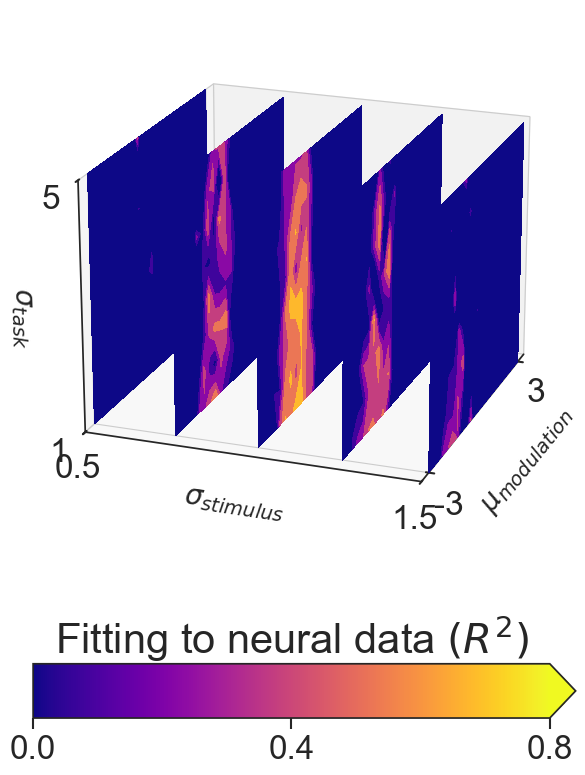

In [10]:
import matplotlib.pylab as pl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

## Fit performance obtained for response-switch

fig = plt.figure(figsize=(20,10))

xx, yy = np.meshgrid(np.linspace(0, 1, np.shape(outputs_grid)[1]), np.linspace(1, 0, np.shape(outputs_grid)[0]))

X = xx
Y = yy

r2_data = (GNG_fit + LR_fit)/2
#r2_data = specia_fit

ax = pl.subplot(projection='3d')

offsets = np.linspace(0,1,5)
levels = np.arange(-1, 1.1, 0.1)



c = 0
for k in range(5):
    contour = ax.contourf(X, Y, r2_data[:,:,k], levels=50, zdir='z', offset=offsets[c], cmap="plasma",vmin=0,vmax=0.8)
    c+=1
    
#fig.colorbar(m,ax=ax)
ax.set_zlim((0,1))
ax.set_xlim((0,1))
#ax.contourf(X, Y, GNG_fit[:,:,4], 100, zdir='z', offset=0.3, cmap="plasma")

ax.set_ylabel('\n' + r'$\mu_{modulation}$',rotation=90,fontsize=20)
ax.set_yticks([0,1],[3,-3])
ax.set_xlabel(r'$\sigma_{task}$',rotation=0,fontsize=20)
ax.set_xticks([0,1],[1,5])
ax.set_zlabel(r'$\sigma_{stimulus}$',fontsize=20)
ax.set_zticks([0,1],[0.5,1.5])

ax.view_init(azim=20, elev=20, vertical_axis='x')

m = plt.cm.ScalarMappable(cmap=cm.plasma)
m.set_clim(0, 0.8)

cbar = plt.colorbar(m,ax=ax,shrink = 0.35, aspect = 10, extend='max',orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([0,0.4,0.8])
cbar.ax.set_title('Fitting to neural data ' + r'$(R^{2})$',fontsize=30)
ax.dist=10.5


#plt.savefig('Plots/SVG/grid_search.SVG', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/grid_search.PNG', dpi = 300,bbox_inches='tight')

"\nplt.savefig('Plots/SVG/best_fit.SVG', dpi = 300,bbox_inches='tight')\nplt.savefig('Plots/PNG/best_fit.PNG', dpi = 300,bbox_inches='tight')\n"

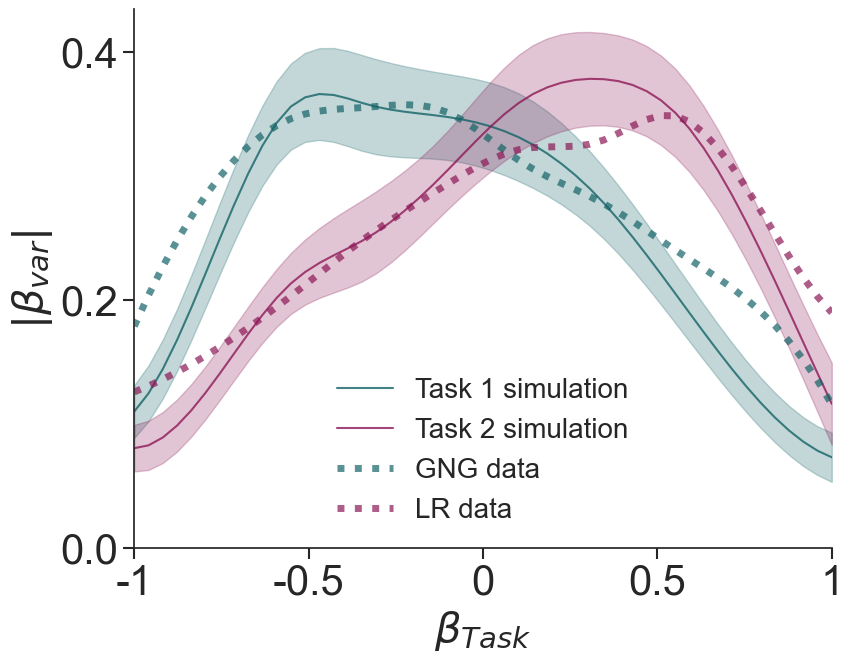

In [16]:
max_value_index = np.unravel_index(np.nanargmax((GNG_fit + LR_fit)/2), ((GNG_fit + LR_fit)/2).shape) ## Parameters providing best fit


# Baseline, context, signal
S = S_s[max_value_index]


GNG_mean_s, LR_mean_s, GNG_error_s, LR_error_s,_,_, x_indices = compute_total_tuning(S,interpolate=True,interp_point=nb_point)

plt.figure(figsize=(9,7))
plt.plot(x_indices, GNG_mean_s,color='#136367',alpha=0.8, label='Task 1 simulation')
plt.fill_between(x_indices, GNG_mean_s - GNG_error_s, GNG_mean_s  + GNG_error_s, color = '#136367', alpha = 0.25)


plt.plot(x_indices, LR_mean_s,color='#8C1857',alpha=0.8, label='Task 2 simulation')
plt.fill_between(x_indices, LR_mean_s - LR_error_s, LR_mean_s  + LR_error_s, color = '#8C1857', alpha = 0.25)


plt.plot(x_indices, GNG_sel,color='#136367',alpha=0.7,linestyle=(0, (1, 1.5)),linewidth=5, label='GNG data')
plt.plot(x_indices, LR_sel,color='#8C1857',alpha=0.7,linestyle=(0, (1, 1.5)),linewidth=5, label='LR data')


plt.xlabel(r'$\beta_{Task}$',fontsize=30)
plt.ylabel(r'$|\beta_{var}|$',fontsize=30)
#plt.axvline(0,color='black',linestyle='dotted',alpha=0.7)


plt.yticks([0,0.2,0.4],fontsize=30)
plt.xlim((-0.9,0.9))
plt.xticks([-0.9,-0.45,0,0.45,0.9],[-1,-0.5,0,0.5,1],fontsize=30)

plt.legend(frameon=False,prop={'size': 20})


"""
plt.savefig('Plots/SVG/best_fit.SVG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/best_fit.PNG', dpi = 300,bbox_inches='tight')
"""

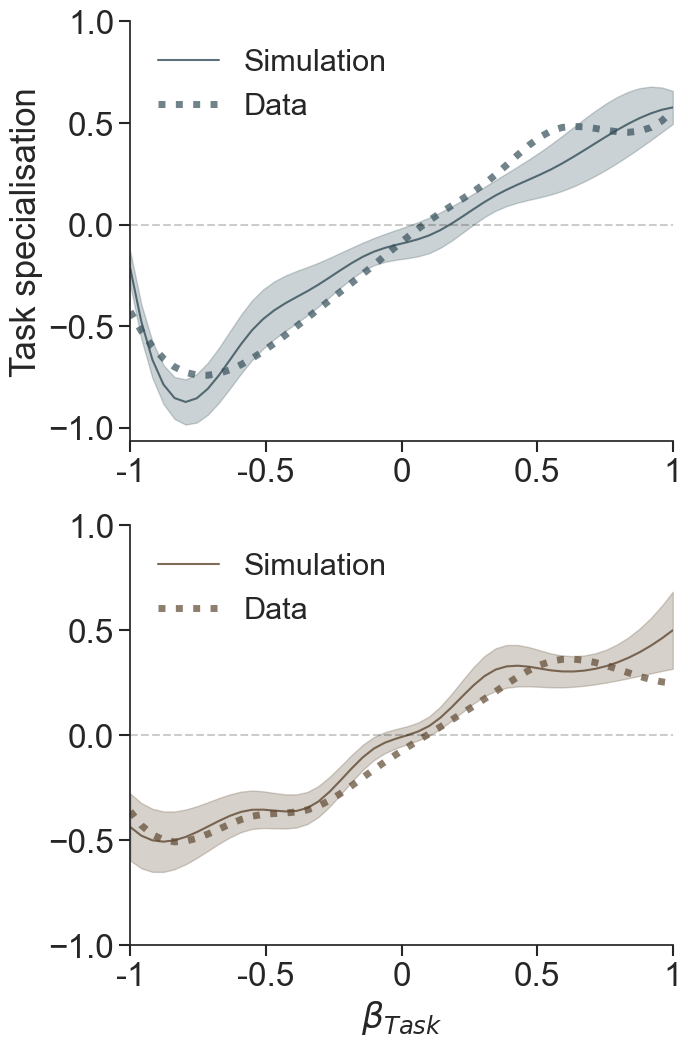

In [329]:
"""
max_value_idx_resp = np.unravel_index(np.nanargmax((GNG_fit + LR_fit)/2), ((GNG_fit + LR_fit)/2).shape)
max_value_idx_rule = np.unravel_index(np.nanargmax((T5_fit + T8_fit)/2), ((T5_fit + T8_fit)/2).shape)
"""

max_value_idx_resp = np.unravel_index(np.nanargmax(spec_resp_fit/2), spec_resp_fit.shape)
max_value_idx_rule = np.unravel_index(np.nanargmax(spec_rule_fit/2), spec_rule_fit.shape)


# Baseline, context, signal
S_resp = S_s[max_value_idx_resp]
S_rule = S_s[max_value_idx_rule]
#S = S_s[1,0,0]

GNG_mean_s, LR_mean_s, GNG_error_s, LR_error_s,spec_resp_s,spec_resp_error_s, x_indices = compute_total_tuning(S_resp,interpolate=True,interp_point=nb_point)
T5_mean_s, T8_mean_s, T5_error_s, T8_error_s, spec_rule_s,spec_rule_error_s, x_indices = compute_total_tuning(S_rule,interpolate=True,interp_point=nb_point)

fig,axs=plt.subplots(2,1,figsize=(7,12))

axs[0].plot(x_indices, spec_resp_s,color='#334E58',alpha=0.8, label='Simulation')
axs[0].fill_between(x_indices, spec_resp_s - spec_resp_error_s, spec_resp_s  + spec_resp_error_s, color = '#334E58', alpha = 0.25)


axs[1].plot(x_indices, spec_rule_s,color='#5F4830',alpha=0.8, label='Simulation')
axs[1].fill_between(x_indices, spec_rule_s - spec_rule_error_s, spec_rule_s  + spec_rule_error_s, color = '#5F4830', alpha = 0.25)


axs[0].plot(x_indices, spec_resp_switch,color='#334E58',alpha=0.7,linestyle=(0, (1, 1.5)),linewidth=5, label='Data')
axs[1].plot(x_indices, spec_rule_switch,color='#5F4830',alpha=0.7,linestyle=(0, (1, 1.5)),linewidth=5, label='Data')


axs[1].set_xlabel(r'$\beta_{Task}$')
axs[0].set_ylabel('Task specialisation')
#plt.axvline(0,color='black',linestyle='dotted',alpha=0.7)


#plt.yticks([0,0.2,0.4])
axs[0].set_xlim((-0.9,0.9))
axs[1].set_xlim((-0.9,0.9))
axs[0].set_xticks([-0.9,-0.45,0,0.45,0.9],[-1,-0.5,0,0.5,1])
axs[1].set_xticks([-0.9,-0.45,0,0.45,0.9],[-1,-0.5,0,0.5,1])
axs[0].set_yticks([-1,-0.5,0,0.5,1])
axs[1].set_yticks([-1,-0.5,0,0.5,1])

axs[0].axhline(0, color='black',alpha=0.2,linestyle='--')
axs[1].axhline(0, color='black',alpha=0.2,linestyle='--')

axs[0].legend(frameon=False,prop={'size': 22},loc='upper left')
axs[1].legend(frameon=False,prop={'size': 22},loc='upper left')


plt.savefig('Plots/SVG/best_fit_spec.SVG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/best_fit_spec.PNG', dpi = 300,bbox_inches='tight')

### Best modulation to fit data

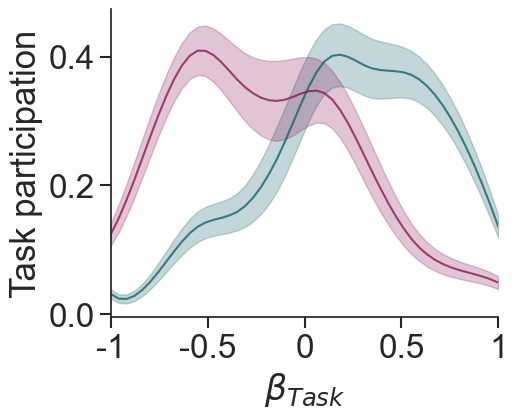

In [95]:
## Easy visualization of participation curves for different combination of parameters


# Baseline, context, signal
S = S_s[5,2,2]  # Provide grid index to display here



GNG_mean_s, LR_mean_s, GNG_error_s, LR_error_s,_,_, x_indices = compute_total_tuning(S,interpolate=True,interp_point=nb_point)

plt.figure(figsize=(5,4))
ax = plt.subplot(111)
ax.plot(x_indices, GNG_mean_s,color='#136367',alpha=0.8, label='Task 1 simulation')
ax.fill_between(x_indices, GNG_mean_s - GNG_error_s, GNG_mean_s  + GNG_error_s, color = '#136367', alpha = 0.25)


ax.plot(x_indices, LR_mean_s,color='#8C1857',alpha=0.8, label='Task 2 simulation')
ax.fill_between(x_indices, LR_mean_s - LR_error_s, LR_mean_s  + LR_error_s, color = '#8C1857', alpha = 0.25)


ax.set_xlabel(r'$\beta_{Task}$')

#plt.axvline(0,color='black',linestyle='dotted',alpha=0.7)

#ax.spines[['left']].set_visible(False)

#ax.set_yticks([])

plt.ylabel('Task participation')

plt.xlim((-0.9,0.9))
plt.xticks([-0.9,-0.45,0,0.45,0.9],[-1,-0.5,0,0.5,1])


plt.savefig('Plots/SVG/positive_mod.SVG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/positive_mod.PNG', dpi = 300,bbox_inches='tight')


In [28]:
mods = np.linspace(-3,0,20)

grid_config_bis = {"Lambda":3, "Noise":5 ,"Modulation std":1, \
               "Context":[3], "Stim":[1], "Modulation mean":mods} # Parameter grid focused on varying modulation input 
                                                                    #to determine which modulation provide best fit to each paradigm

nb_models = 20

io_grids = []
for n in range(nb_models):
    io_grid_n,_,_ = grid_search(grid_config_bis)
    io_grids.append(io_grid_n)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
resp_switch_data = pd.read_pickle('../Task-change/Pseudo_pop/Models/sel_analysis.pickle')
rule_switch_data = pd.read_pickle('../Rule-switch/Pseudo_pop/Models/sel_analysis.pickle')


GNG_sel = resp_switch_data['GNG'][0]
LR_sel = resp_switch_data['LR'][0]

T5_sel = rule_switch_data['T5'][0]
T8_sel = rule_switch_data['T8'][0]


nb_point = len(GNG_sel)

def data_fit(target1,target2,sel_mat) :
    task1_sel_sim = np.zeros(np.shape(sel_mat), dtype=object)
    task2_sel_sim = np.zeros(np.shape(sel_mat), dtype=object)
    specia_sim = np.zeros(np.shape(sel_mat), dtype=object)
        
    task1_fit = np.zeros(np.shape(sel_mat))
    task2_fit = np.zeros(np.shape(sel_mat))
    specia_fit = np.zeros(np.shape(sel_mat))
    for i in range(np.shape(sel_mat)[0]) :
        for j in range(np.shape(sel_mat)[1]) :
            for k in range(np.shape(sel_mat)[2]) :
                task1_s, task2_s, task1_error_s, task2_error_s,_,_, x_indices = compute_total_tuning(sel_mat[i,j,k],interpolate=True,interp_point=nb_point)
                
                task1_sel_sim[i,j,k] = task1_s
                task2_sel_sim[i,j,k] = task2_s
                
                task1_fit[i,j,k] = compute_R2(target1,task1_sel_sim[i,j,k])
                task2_fit[i,j,k] = compute_R2(target2,task2_sel_sim[i,j,k])


    return task1_sel_sim, task2_sel_sim, task1_fit, task2_fit


resp_switch_best_idx = []
rule_switch_best_idx = []
for io_grid in io_grids :  
    GNG_sel_sim, LR_sel_sim, GNG_fit, LR_fit = data_fit(GNG_sel,LR_sel,fit_grid(io_grid))
    T5_sel_sim, T8_sel_sim, T5_fit, T8_fit = data_fit(T5_sel,T8_sel,fit_grid(io_grid))

    resp_switch_best_idx.append(np.argmax(np.squeeze((GNG_fit+LR_fit)/2)))
    rule_switch_best_idx.append(np.argmax(np.squeeze((T5_fit+T8_fit)/2)))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

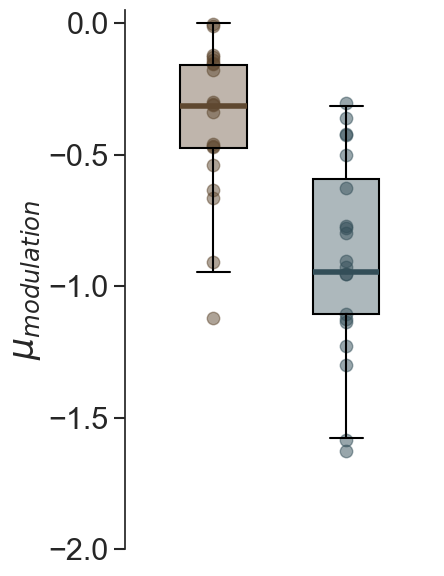

In [99]:
plt.figure(figsize=(4,7))

def set_color(bplot,colors) :
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        #patch.set_alpha(0.4)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)

    for median, color in zip(bplot['medians'], colors):
        median.set_color(color)
        median.set_linewidth(4)
        median.set_alpha(1)

    
    for mean, color in zip(bplot['means'], colors):
        mean.set_color(color)
        mean.set_alpha(0.5)
        mean.set_linewidth(1.5)

    for whisk in bplot['whiskers']:
        whisk.set_linewidth(1.5)

    for caps in bplot['caps']:
        caps.set_linewidth(1.5)


colors= [('#5F4830',0.4),('#334E58',0.4)]

plt.scatter([0 for _ in range(len(mods[rule_switch_best_idx]))],mods[rule_switch_best_idx]+np.random.normal(0,0.03,size=len(mods[rule_switch_best_idx]))\
            ,marker='o',alpha=0.5,c=colors[0],s=80)

plt.scatter([0.3 for _ in range(len(mods[resp_switch_best_idx]))],mods[resp_switch_best_idx]+np.random.normal(0,0.03,size=len(mods[resp_switch_best_idx]))\
            ,marker='o',alpha=0.5,c=colors[1],s=80)


bplot = plt.boxplot([mods[rule_switch_best_idx],mods[resp_switch_best_idx]],positions=[0,0.3],
                    patch_artist=True,bootstrap=1000,showfliers=False)
set_color(bplot,colors)



ax = plt.gca()

ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)

plt.ylim(-2,0.05)
plt.xlim(-0.2,0.5)
#plt.xlim((-0.3,0.9))
plt.yticks([-2,-1.5,-1,-0.5,0],fontsize=22)

plt.ylabel(r'$\mu_{modulation}$',fontsize=25)

plt.savefig('Plots/SVG/best_mod_box.SVG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/best_mod_box.PNG', dpi = 300,bbox_inches='tight')

In [188]:
from scipy.stats import mannwhitneyu


print(mannwhitneyu(mods[rule_switch_best_idx],mods[resp_switch_best_idx]))

MannwhitneyuResult(statistic=302.0, pvalue=0.00560357050983553)


### Grid ePAIRS

In [1095]:
N = 100

grid_config2 = {"Lambda":3, "Noise":5 ,"Modulation std":1, \
               "Context":np.linspace(1,5,20), "Stim":[1], "Modulation mean":np.linspace(-3,3,20)}

IO_grid2,_,_ = grid_search(grid_config2)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [1097]:
S_s2 = np.squeeze(fit_grid(IO_grid2))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

## ePAIRS

In [1098]:
from scipy.stats import pearsonr
from tqdm.auto import tqdm
def compute_PAIRS(S,k=2) :
    """Method computing angle with nearest neighbors (k) distribution"""
    sel_dist = np.zeros((np.shape(S)[1],np.shape(S)[1]))

    for i in tqdm(range(np.shape(S)[1])):
        for j in range(i,np.shape(S)[1]):
            #sel_dist[i,j] = np.linalg.norm(S[:,i]-S[:,j],ord=2)
            sel_dist[i,j] = 1-np.dot(S[:,j],S[:,i])/(np.linalg.norm(S[:,i],ord=2)*np.linalg.norm(S[:,j],ord=2))  #cosine distance
            sel_dist[j,i] = sel_dist[i,j]

    PAIRS = np.zeros(np.shape(S)[1])
    for ne in range(np.shape(sel_dist)[0]) :
        neighbors = np.argsort(np.concatenate((sel_dist[ne,:ne],np.array([2]),sel_dist[ne,(ne+1):]),axis=0))[:k]
        PAIRS[ne] = np.mean([np.abs(angle_between(S[:,ne],S[:,neighbor])) for neighbor in neighbors])

    return PAIRS

def grid_PAIRS(S_s, nb_random = 50) :
    """Method which performs ePAIRS analysis across model from a grid of parameter"""
    PAIRS_stats = np.zeros(shape=(np.shape(S_s)[0],np.shape(S_s)[1]), dtype='object')
    PAIRS_effects = np.zeros(shape=(np.shape(S_s)[0],np.shape(S_s)[1]), dtype='object')
    for i in tqdm(range(np.shape(S_s)[0])):
        for j in range(np.shape(S_s)[1]):
            s = S_s[i,j].T
            pairs = compute_PAIRS(s, disable_tqdm=True)
    
            random_PAIRS = [compute_PAIRS(np.random.multivariate_normal(np.mean(s,axis=1), np.cov(s),size=N).T, disable_tqdm=True) for _ in range(nb_random)]
            
            PAIRS_stats[i,j] = np.mean([(np.nanmedian(r_pairs) - np.nanmedian(pairs))/   \
            np.nanmedian(r_pairs) for r_pairs in random_PAIRS])
    
            PAIRS_effects[i,j] = np.mean([(np.nanmedian(r_pairs) - np.nanmedian(pairs))/   \
            np.nanstd(r_pairs) for r_pairs in random_PAIRS])

    return PAIRS_stats, PAIRS_effects

In [1099]:
PAIRS_stats, PAIRS_effects = grid_PAIRS(S_s2)

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_37205/3564618742.py:32: RuntimeWarning: invalid value encountered in arccos
  delta = np.arccos(np.dot(v1_u, v2_u))*180/np.pi


/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_37205/2000624062.py:23: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


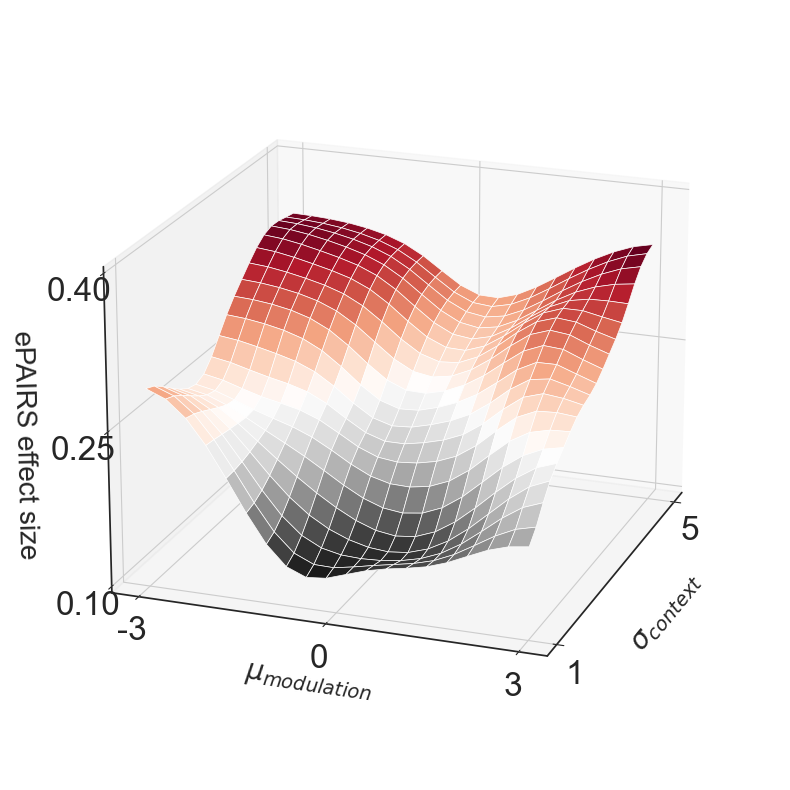

In [1117]:
from scipy.ndimage import gaussian_filter

fig = plt.figure(figsize=(20,10))

X, Y = np.meshgrid(np.linspace(0, 1, np.shape(IO_grid2)[0]), np.linspace(1, 0, np.shape(IO_grid2)[1]))
Z = gaussian_filter(PAIRS_effects.astype(float),sigma=2)

ax = pl.subplot(projection='3d')

ax.plot_surface(X, Y, Z,cmap='RdGy_r',edgecolor='white',linewidth=0.5)


ax.view_init(azim=200, elev=20, vertical_axis='z')

#ax.set_ylabel('\n Global modulation',rotation=90,fontsize=20)
ax.set_ylabel('\n' + r'$\mu_{modulation}$',rotation=90,fontsize=20)
ax.set_yticks([0,0.5,1],[3,0,-3])
ax.set_xlabel('\n' + r'$\sigma_{context}$',fontsize=20)
ax.set_xticks([0,1],[1,5])

ax.set_zlabel('\n \n ePAIRS effect size',rotation=0,fontsize=20)
ax.set_zticks([0.1,0.25,0.4])
ax.dist = 11


plt.savefig('Plots/SVG/grid_ePAIRS.SVG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/grid_ePAIRS.PNG', dpi = 300,bbox_inches='tight')

## Gaussian mixture

In [121]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

## Gaussian mixture on model with best fit to response-switch data

best_idx = (7,3,2)
#S = S.T
S = S_s[best_idx].T
gm = BayesianGaussianMixture(n_components=3 ,n_init = 5, max_iter=100)

gm.fit(S.T)

print(gm.score(S.T))
#print(gm.bic(S.T))
prob = gm.predict_proba(S.T)

0.6424244318428161


### Cross-validation

In [125]:
from sklearn.model_selection import KFold, GridSearchCV, RepeatedKFold, cross_validate
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from tqdm.auto import tqdm

def gm_components_estimation(S_mat, n_repeat=50) :
    """Determine the number of components to keep in Gaussian mixture through a 2-fold cross-validation procedure (50 reps)"""
    gm_scores = []

    rkf = RepeatedKFold(n_splits = 2, n_repeats = n_repeat)
    for n_comp in tqdm(range(1,6)) :
        gm = BayesianGaussianMixture(n_components=n_comp ,n_init = 5, max_iter=100)
        
        cv_scores = cross_validate(gm,S_mat.T,cv=rkf)

        gm_scores.append(cv_scores['test_score'])

    return np.array(gm_scores)

In [127]:
gm_scores_full = gm_components_estimation(S)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


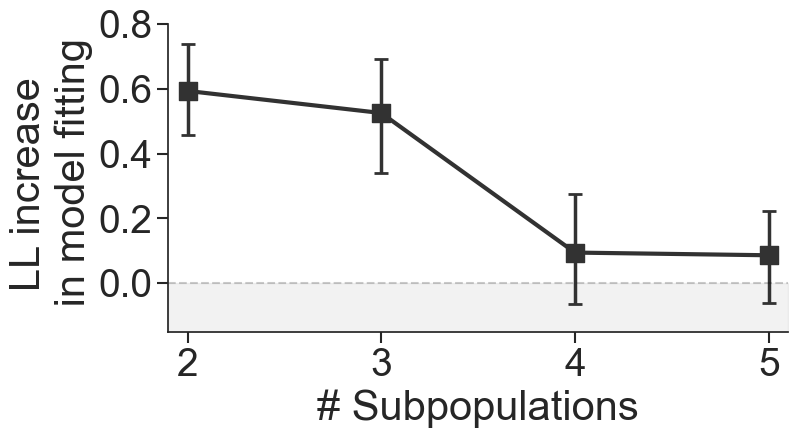

In [140]:
import matplotlib as mpl


plt.figure(figsize=(8,4))

def set_caps(caps) :
    for cap in caps:
        cap.set_color('#323232')
        cap.set_markeredgewidth(2)


yerr =  np.abs(np.mean(np.diff(gm_scores_full,axis=0),axis=1) - np.percentile(np.diff(gm_scores_full,axis=0),(5,95),axis=1))

_,caps,_ = plt.errorbar([2,3,4,5],np.mean(np.diff(gm_scores_full,axis=0),axis=1),yerr=yerr,linewidth=3,capsize=5,elinewidth=2.5,color='#323232')

set_caps(caps)

plt.scatter([2,3,4,5],np.mean(np.diff(gm_scores_full,axis=0),axis=1),marker = 's',s=150, color='#323232')
#plt.scatter([2,3,4,5],np.percentile(np.diff(gm_scores_full,axis=0),5,axis=1),marker='s', s=120,color='#276690')

plt.fill_between([1.9,3,4,5.1],-0.2,0, color='black',alpha=0.05)
plt.axhline(0,color="black",linestyle='--',alpha=0.2)

plt.xlabel('# Subpopulations',fontsize=30)
plt.xlim((1.9,5.1))
plt.xticks([2,3,4,5],fontsize=28)

plt.ylabel('LL increase \n in model fitting',fontsize=30)

#plt.ylim((-0.15,0.4))
plt.ylim((-0.15,0.8))

#plt.yticks([-0.05,0,0.05,0.1])
plt.yticks([0,0.2,0.4,0.6,0.8],fontsize=28)


plt.savefig('Plots/SVG/gm_components.SVG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/gm_components.PNG', dpi = 300,bbox_inches='tight')

### Cloud of dots plot

In [1221]:
pop1 = prob[:,0] >= 0.9
pop2 = prob[:,1] >= 0.9
pop3 = prob[:,2] >= 0.9

pops = [pop1,pop2,pop3]

S_pop = [S[:,pop1],S[:,pop2],S[:,pop3]]


mean_ctx_s = [np.mean(S_pop[0][0,:]),np.mean(S_pop[1][0,:]),np.mean(S_pop[2][0,:])]
print(mean_ctx_s)

S_A = S_pop[np.argsort(mean_ctx_s)[0]]
popA = pops[np.argsort(mean_ctx_s)[0]]

S_B = S_pop[np.argsort(mean_ctx_s)[2]]
popB = pops[np.argsort(mean_ctx_s)[2]]

S_0 = S_pop[np.argsort(mean_ctx_s)[1]]
pop0 = pops[np.argsort(mean_ctx_s)[1]]

[0.8728440022914176, -0.8542316709261265, 0.09705972029134095]


"\nplt.savefig('Plots/SVG/gm_cattask1_task_' + mode + '.SVG', dpi = 300,bbox_inches='tight')\nplt.savefig('Plots/PNG/gm_cattask1_task_' + mode + '.PNG', dpi = 300,bbox_inches='tight')\n"

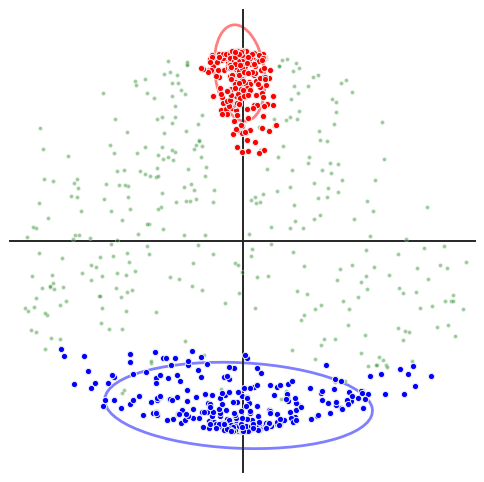

In [1222]:
plt.figure(figsize=(6,6))

plt.xlim((-0.7,0.7))
plt.ylim((-1.2,1.2))

ax = plt.gca()

mode = 'center'

if mode == 'center' :

    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    ax.spines['left'].set_linewidth(1.4)
    ax.spines['bottom'].set_linewidth(1.4)
    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
         
    plt.xticks([])
    plt.yticks([])

elif mode == 'normal' : 
    ax.spines[['top','right']].set_visible(False)
    
    plt.yticks([-1,0,1],fontsize=25)
    plt.xticks([-0.5,0,0.5],fontsize=25)
    ax.set_xlabel(r'$\beta_{Category \ Task 1}$')
    ax.set_ylabel(r'$\beta_{Task}$')



plt.scatter(S_0[1,:],S_0[0,:], color = 'green', s = 8, alpha = 0.4,label='Population 0'\
            ,edgecolors='#EEEEEE',lw=0.7,antialiased=True, zorder=3)
plt.scatter(S_B[1,:],S_B[0,:], color = 'red', s = 20, alpha = 1,label='Population LR'\
            ,edgecolors='#EEEEEE',lw=0.7,antialiased=True, zorder=3)
plt.scatter(S_A[1,:],S_A[0,:], color = 'blue', s = 20, alpha = 1,label='Population GNG'\
            ,edgecolors='#EEEEEE',lw=0.7,antialiased=True, zorder=3)

#plt.legend(frameon=False)

confidence_ellipse(S_B[1,:],S_B[0,:],ax, edgecolor='red', n_std=2, alpha = 0.5,linewidth=2)
confidence_ellipse(S_A[1,:],S_A[0,:],ax, edgecolor='blue', n_std=2, alpha = 0.5,linewidth=2)

"""
plt.savefig('Plots/SVG/gm_cattask1_task_' + mode + '.SVG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/gm_cattask1_task_' + mode + '.PNG', dpi = 300,bbox_inches='tight')
"""

/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_37205/487273752.py:34: RuntimeWarning: overflow encountered in exp
  y = A*np.exp(-1*B*(x-C)**2)


"\nplt.savefig('Plots/SVG/gain_' + pop_plot + '.SVG', dpi = 300,bbox_inches='tight')\nplt.savefig('Plots/PNG/gain_' + pop_plot + '.PNG', dpi = 300,bbox_inches='tight')\n"

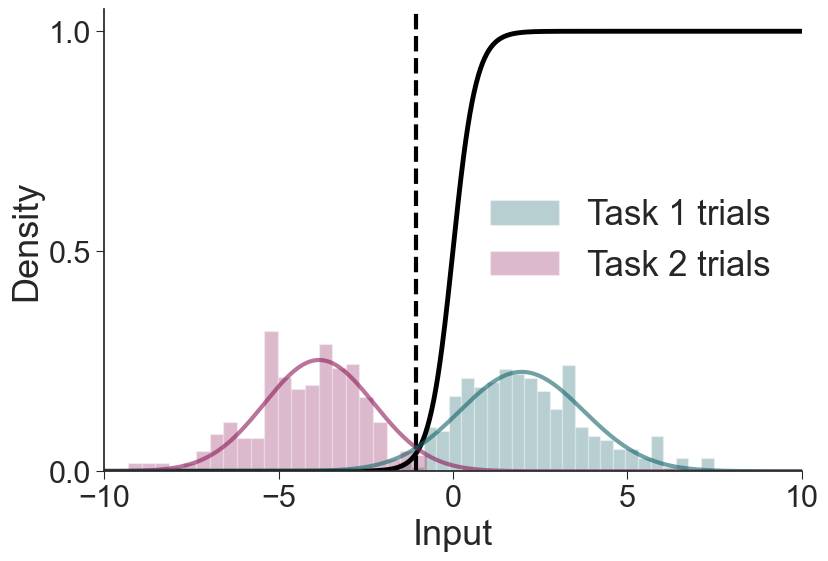

In [1249]:
from scipy.optimize import curve_fit 

plt.figure(figsize=(9,6))

plot_range=(-10,10)

x_plot = np.linspace(plot_range[0],plot_range[1],1000)

pop_plot = 'popA'
if pop_plot == 'popA' :
    pop = popA
elif pop_plot == 'popB' :
    pop = popB
elif pop_plot == 'pop0' :
    pop = pop0


projs = proj_grid[best_idx]

proj_context = projs[1,:]
proj_mod = projs[2,:]

nb_bin = 25

plt.plot(x_plot, sygmoid(x_plot,3),color='black',linewidth=3.5)

h2 = plt.hist(-proj_context[pop] + proj_mod[pop], density=True,alpha=0.3, color='#136367', bins=nb_bin ,edgecolor = "white",label='Task 1 trials')
h1 = plt.hist(proj_context[pop] + proj_mod[pop], density=True,alpha=0.3, color='#8C1857', bins=nb_bin ,edgecolor = "white",label='Task 2 trials')

plt.axvline(np.mean(proj_mod[pop]), linestyle='--',color='black',linewidth=3)


def Gauss(x, A, B, C): 
    y = A*np.exp(-1*B*(x-C)**2) 
    return y 

parameters1, covariance = curve_fit(Gauss, h1[1][1:], h1[0]) 
fit_A1 = parameters1[0] 
fit_B1 = parameters1[1]
fit_C1 = parameters1[2]


parameters2, covariance = curve_fit(Gauss, h2[1][1:], h2[0]) 
fit_A2 = parameters2[0] 
fit_B2 = parameters2[1]
fit_C2 = parameters2[2]

fit_y1 = Gauss(x_plot, fit_A1, fit_B1, fit_C1)  
fit_y2 = Gauss(x_plot, fit_A2, fit_B2, fit_C2) 

plt.plot(x_plot,fit_y1,color='#8C1857',alpha=0.6,linewidth=3)
plt.plot(x_plot,fit_y2,color='#136367',alpha=0.6,linewidth=3)

plt.legend(frameon=False)

plt.yticks([0,0.5,1],fontsize=22)
plt.xticks([-10,-5,0,5,10],fontsize=22)
plt.xlim(plot_range)

plt.xlabel('Input',fontsize=26)
plt.ylabel('Density',fontsize=26)
"""
plt.savefig('Plots/SVG/gain_' + pop_plot + '.SVG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/gain_' + pop_plot + '.PNG', dpi = 300,bbox_inches='tight')
"""

## Readout

In [63]:
from sklearn.linear_model import Perceptron

p1 = Perceptron()
p2 = Perceptron()

X = outputs_grid[7,2,2]
#X = outputs_grid[10,3,2]
# Lick readout: 1=lick, -1=no lick
lick_label = np.array([-1 for _ in range(n_trials//4)] + [1 for _ in range(3*n_trials//4)]) 

# Head direction readout: 0=middle spout, -1=left spout, 1=right spout
dir_label = np.array([0 for _ in range(n_trials//2)] + [-1 for _ in range(n_trials//4)] + [1 for _ in range(n_trials//4)]) 


y = np.stack((lick_label,dir_label)).T

p1.fit(X,lick_label) # Feat one perceptron to reproduce lick response
p2.fit(X,dir_label) # Feat another perceptron to reproduce lick direction response

print(p1.score(X,lick_label))
print(p2.score(X,dir_label))

1.0
1.0


In [495]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

def compute_score_across_fold(x) :
    """Compute perceptron scores in performing response-switch task with 2 fold cross-validation"""
    kf = RepeatedKFold(n_splits=2,n_repeats=10)
    
    scores_fold = []
    for i, (train_idx, test_idx) in enumerate(kf.split(x)):
        p1 = Perceptron()
        p2 = Perceptron()

        p1.fit(x[train_idx],lick_label[train_idx])
        p1_error = p1.predict(x[test_idx]) - lick_label[test_idx]
    
        p2.fit(x[train_idx],dir_label[train_idx])
        p2_error = p2.predict(x[test_idx]) - dir_label[test_idx]
    
        score_GNG = 2*np.sum(((p1_error == 0)&(p2_error == 0))[:len(p1_error)//2])/len(p1_error)
        score_LR = 2*np.sum(((p1_error == 0)&(p2_error == 0))[len(p1_error)//2:])/len(p1_error)

        scores_fold.append([score_GNG,score_LR])

    return np.array(scores_fold)

X = outputs_grid[7,2,2]  # Best fit model on response-switch
scores_fold = compute_score_across_fold(X)

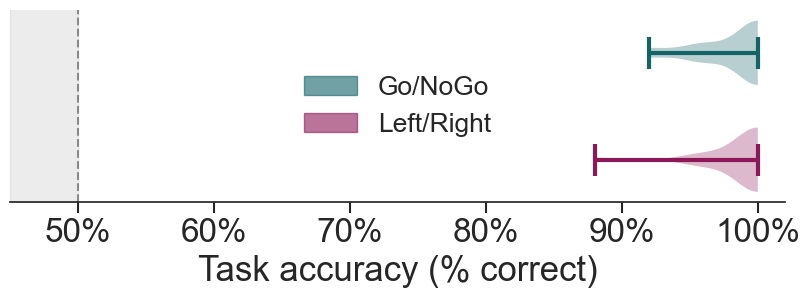

In [499]:
import matplotlib.patches as mpatches

plt.figure(figsize=(10,2.5))
plt.xlim(0.45,1.02)
plt.ylim(0.6,2.4)
plt.xticks([0.5,0.6,0.7,0.8,0.9,1],['50%','60%','70%','80%','90%','100%'])
plt.xlabel('Task accuracy (% correct)')
plt.yticks([])

plt.axvline(0.5,linestyle='--',color='black',alpha=0.4)
plt.fill_betweenx([0.5,2.5],0.45,0.5,color='grey',alpha=0.15)
violin = plt.violinplot(scores_fold[:,[1,0]],vert=False,widths=0.6)

set_violin_color(violin,['#8C1857','#136367'])
#set_violin_color(violin,['#334E58'])
ax = plt.gca()
ax.spines['left'].set_visible(False)

labels = ['Go/NoGo','Left/Right',]
patches = []
def add_label(violin):
    c = 0
    for body in violin["bodies"][::-1]:
        color = body.get_facecolor().flatten()
        patches.append((mpatches.Patch(color=color,alpha=0.6), labels[c]))
        c+=1

add_label(violin)

plt.legend(*zip(*patches), loc='center',prop={'size': 19})

plt.savefig('Plots/SVG/model_accuracy_task.SVG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/model_accuracy_task.PNG', dpi = 300,bbox_inches='tight')

## Information

In [1065]:
## Exploration on the nature of information each population provides

nb_bins = 20
def compute_prob(data) :
    hist = np.histogram(data,nb_bins,range=(0,1))[0]
    return hist/np.sum(hist)

eps = 0
def MI(XY_mat,pX,pY) :
    # XY matrix must be the matrix of X conditionned on Y
    mi = 0
    for i in range(np.shape(XY_mat)[0]) :
        for j in range(np.shape(XY_mat)[1]) :
            if (pY[i] <= eps) or (pX[j] <= eps) or (XY_mat[i,j] <= eps) :
                mi+=0
            else :
                #print(pY[i])
                #print(pX[j])
                mi+=pY[i]*XY_mat[i,j]*np.log2(pY[i]*XY_mat[i,j]/(pY[i]*pX[j]))
    return mi

def cond_MI(XYZ_mat,XZ_mat,pX,pY,pZ) :
    # We compute the MI between X and Y conditionned on Z
    # Here we suppose the independence between Y and Z. XYZ matrix is the matrix of X conditionned on Y and Z.
    mi = 0
    for i in range(np.shape(XYZ_mat)[0]) :
        for j in range(np.shape(XYZ_mat)[1]) :
            for k in range(np.shape(XYZ_mat)[2]) :
                if (XZ_mat[j,k] <= eps) or (XYZ_mat[i,j,k] <= eps):
                    mi += 0
                else :
                    mi += pY[i]*pZ[j]*XYZ_mat[i,j,k]*np.log2(XYZ_mat[i,j,k]/XZ_mat[j,k])

    return mi

In [641]:
A_data = IO_grid[3,2,2]
s_data = np.array(stim)
c_data = np.array(context)

pC = np.array([0.5,0.5])
pS = np.array([0.5,0.5])
A_matrices = np.array([compute_prob(A_data[:,n]) for n in range(np.shape(A_data)[1])])
AS_matrices = np.array([[compute_prob(A_data[s_data==-1,n]),compute_prob(A_data[s_data==1,n])] for n in range(np.shape(A_data)[1])])
AC_matrices = np.array([[compute_prob(A_data[c_data==-1,n]),compute_prob(A_data[c_data==1,n])] for n in range(np.shape(A_data)[1])])


ACS_matrices = np.array([[[compute_prob(A_data[(s_data==-1)&(c_data==-1),n]),compute_prob(A_data[(s_data==1)&(c_data==-1),n])],\
                     [compute_prob(A_data[(s_data==-1)&(c_data==1),n]),compute_prob(A_data[(s_data==1)&(c_data==1),n])]] for n in range(np.shape(A_data)[1])])

#YSC shape : neuron x context x stim x bins

In [643]:
MI_AS_s = []
MI_AC_s = []
MI_AC_S_s = []

for n in range(np.shape(A_matrices)[0]) :
    pA = A_matrices[n]
    AS_mat = AS_matrices[n]
    AC_mat = AC_matrices[n]
    ACS_mat = ACS_matrices[n]

    MI_AS_s.append(MI(AS_mat,pA,pS))
    MI_AC_s.append(MI(AC_mat,pA,pC))
    MI_AC_S_s.append(cond_MI(ACS_mat,AS_mat,pA,pC,pS))


MI_AS_s = np.array(MI_AS_s)
MI_AC_s = np.array(MI_AC_s)
MI_AC_S_s = np.array(MI_AC_S_s)

### Information grid

In [1185]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from tqdm.auto import tqdm

def get_pop(prob,S) :
    pop1 = prob[:,0] >= 0.9
    pop2 = prob[:,1] >= 0.9
    pop3 = prob[:,2] >= 0.9
    
    pops = [pop1,pop2,pop3]
    
    S_pop = [S[:,pop1],S[:,pop2],S[:,pop3]]
    
    mean_ctx_s = [np.mean(S_pop[0][0,:]),np.mean(S_pop[1][0,:]),np.mean(S_pop[2][0,:])]
    
    popA = pops[np.argsort(mean_ctx_s)[0]]
    popB = pops[np.argsort(mean_ctx_s)[2]]
    pop0 = pops[np.argsort(mean_ctx_s)[1]]

    return popA, popB, pop0

def compute_UI_SYN_pop(S_grid,IO_grid,mean_only=True) :
    s_data = np.array(stim)
    c_data = np.array(context)
    pC = np.array([0.5,0.5])
    pS = np.array([0.5,0.5])
    
    MI_AC_popA = []
    MI_AS_popA = []
    MI_AC_S_popA = []
    
    MI_AC_popB = []
    MI_AS_popB = []
    MI_AC_S_popB = []
    
    MI_AC_pop0 = []
    MI_AS_pop0 = []
    MI_AC_S_pop0 = []


    MI_AC_tot = []
    MI_AS_tot = []
    MI_AC_S_tot = []
    for i in tqdm(range(len(S_grid))) :
        S = S_grid[i].T
        A_data = np.squeeze(IO_grid[i])
    
        gm = BayesianGaussianMixture(n_components=3 ,n_init = 5, max_iter=100)
        
        gm.fit(S.T)
        
        prob = gm.predict_proba(S.T)
    
        popA, popB, pop0 = get_pop(prob,S)
        
    
        A_matrices = np.array([compute_prob(A_data[:,n]) for n in range(np.shape(A_data)[1])])
        AS_matrices = np.array([[compute_prob(A_data[s_data==-1,n]),compute_prob(A_data[s_data==1,n])] for n in range(np.shape(A_data)[1])])
        AC_matrices = np.array([[compute_prob(A_data[c_data==-1,n]),compute_prob(A_data[c_data==1,n])] for n in range(np.shape(A_data)[1])])
        
        
        ACS_matrices = np.array([[[compute_prob(A_data[(s_data==-1)&(c_data==-1),n]),compute_prob(A_data[(s_data==1)&(c_data==-1),n])],\
                             [compute_prob(A_data[(s_data==-1)&(c_data==1),n]),compute_prob(A_data[(s_data==1)&(c_data==1),n])]] for n in range(np.shape(A_data)[1])])
    
        MI_AS_s = []
        MI_AC_s = []
        MI_AC_S_s = []
        for n in range(np.shape(A_matrices)[0]) :
            pA = A_matrices[n]
            AS_mat = AS_matrices[n]
            AC_mat = AC_matrices[n]
            ACS_mat = ACS_matrices[n]
            
            MI_AS_s.append(MI(AS_mat,pA,pS))
            MI_AC_s.append(MI(AC_mat,pA,pC))
            MI_AC_S_s.append(cond_MI(ACS_mat,AS_mat,pA,pC,pS))
    
        
        MI_AS_s = np.array(MI_AS_s)
        MI_AC_s = np.array(MI_AC_s)
        MI_AC_S_s = np.array(MI_AC_S_s)

        if mean_only :
        
            MI_AC_popA.append(np.mean(MI_AC_s[popA]))
            MI_AC_popB.append(np.mean(MI_AC_s[popB]))
            MI_AC_pop0.append(np.mean(MI_AC_s[pop0]))
            
            MI_AS_popA.append(np.mean(MI_AS_s[popA]))
            MI_AS_popB.append(np.mean(MI_AS_s[popB]))
            MI_AS_pop0.append(np.mean(MI_AS_s[pop0]))
        
            MI_AC_S_popA.append(np.mean(MI_AC_S_s[popA]))
            MI_AC_S_popB.append(np.mean(MI_AC_S_s[popB]))
            MI_AC_S_pop0.append(np.mean(MI_AC_S_s[pop0]))

            MI_AC_tot.append(np.mean(MI_AC_s[popA+popB+pop0]))
            MI_AS_tot.append(np.mean(MI_AS_s[popA+popB+pop0]))
            MI_AC_S_tot.append(np.mean(MI_AC_S_s[popA+popB+pop0]))


        else : 
            MI_AC_popA.append(MI_AC_s[popA])
            MI_AC_popB.append(MI_AC_s[popB])
            MI_AC_pop0.append(MI_AC_s[pop0])
            
            MI_AS_popA.append(MI_AS_s[popA])
            MI_AS_popB.append(MI_AS_s[popB])
            MI_AS_pop0.append(MI_AS_s[pop0])
        
            MI_AC_S_popA.append(MI_AC_S_s[popA])
            MI_AC_S_popB.append(MI_AC_S_s[popB])
            MI_AC_S_pop0.append(MI_AC_S_s[pop0])

    
    MI_AC_popA = np.squeeze(np.array(MI_AC_popA))
    MI_AC_popB = np.squeeze(np.array(MI_AC_popB))
    MI_AC_pop0 = np.squeeze(np.array(MI_AC_pop0))
    
    MI_AS_popA = np.squeeze(np.array(MI_AS_popA))
    MI_AS_popB = np.squeeze(np.array(MI_AS_popB))
    MI_AS_pop0 = np.squeeze(np.array(MI_AS_pop0))
    
    MI_AC_S_popA = np.squeeze(np.array(MI_AC_S_popA))
    MI_AC_S_popB = np.squeeze(np.array(MI_AC_S_popB))
    MI_AC_S_pop0 = np.squeeze(np.array(MI_AC_S_pop0))

    MI_AC_tot = np.squeeze(np.array(MI_AC_tot))
    MI_AS_tot = np.squeeze(np.array(MI_AS_tot)) 
    MI_AC_S_tot = np.squeeze(np.array(MI_AC_S_tot))

    if mean_only :
        return np.array([[MI_AC_popA, MI_AS_popA, MI_AC_S_popA],\
                         [MI_AC_popB, MI_AS_popB, MI_AC_S_popB],\
                        [MI_AC_pop0, MI_AS_pop0, MI_AC_S_pop0],
                        [MI_AC_tot, MI_AS_tot, MI_AC_S_tot]])
    else :
        return np.array([MI_AC_popA, MI_AS_popA, MI_AC_S_popA]),\
        np.array([MI_AC_popB, MI_AS_popB, MI_AC_S_popB]),\
        np.array([MI_AC_pop0, MI_AS_pop0, MI_AC_S_pop0])

In [1215]:
N=1000

grid_config3 = {"Lambda":3, "Noise":5 ,"Modulation std":1, \
               "Context":[3], "Stim":[1], "Modulation mean":np.linspace(-3,0,7)}
all_MIs = []
for k in tqdm(range(30)) :
    IO_grid3,_,_ = grid_search(grid_config3)
    S_s3 = np.squeeze(fit_grid(IO_grid3))
    MIs = compute_UI_SYN_pop(S_s3,IO_grid3)

    all_MIs.append(MIs)

all_MIs = np.array(all_MIs)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

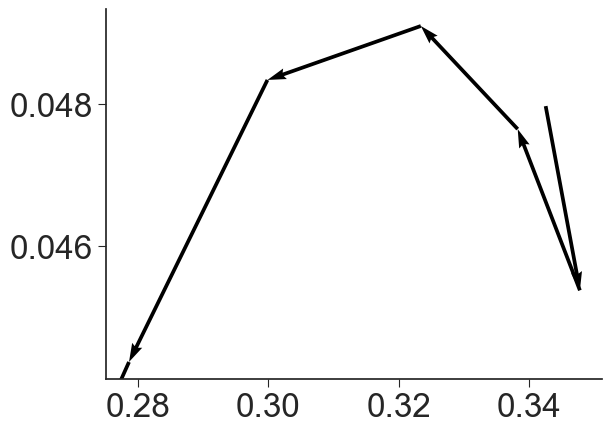

In [1033]:
plt.quiver(xtot[:-1], ytot[:-1], xtot[1:]-xtot[:-1], ytot[1:]-ytot[:-1], scale_units='xy', angles='xy', scale=1,color='black')

/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_37205/3489591283.py:47: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xA[bfit_idx],yA[bfit_idx],s=size*3,marker='s', c=blues[bfit_idx],edgecolors='darkorange',linewidths=1.8)
/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_37205/3489591283.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xB[bfit_idx],yB[bfit_idx],s=size*3,marker

"\nplt.savefig('Plots/SVG/MI_traj.SVG', dpi = 300,bbox_inches='tight')\nplt.savefig('Plots/PNG/MI_traj.PNG', dpi = 300,bbox_inches='tight')\n"

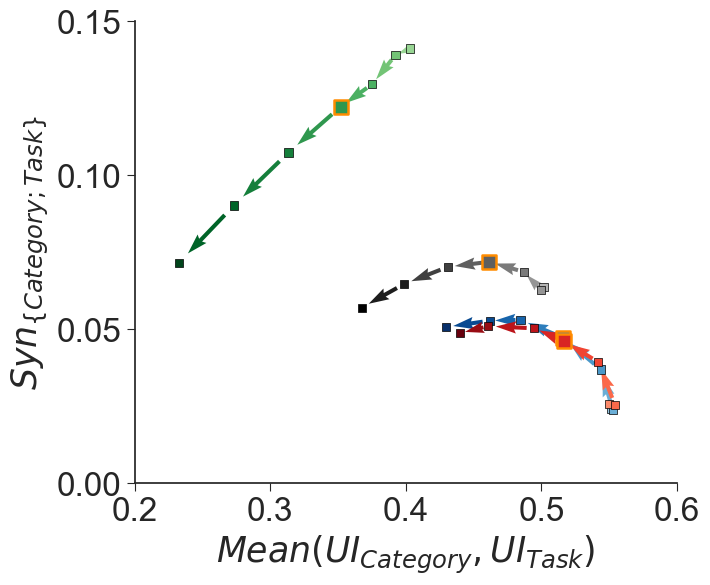

In [1217]:
import matplotlib as mpl

plt.figure(figsize=(7,6))

plt.xlim((0.2,0.6))
plt.ylim((0,0.15))


greens = mpl.colormaps['Greens'](np.linspace(0.4,1,len(grid_config3['Modulation mean'])))
blues = mpl.colormaps['Blues'](np.linspace(0.4,1,len(grid_config3['Modulation mean'])))
reds = mpl.colormaps['Reds'](np.linspace(0.4,1,len(grid_config3['Modulation mean'])))
greys = mpl.colormaps['Greys'](np.linspace(0.4,1,len(grid_config3['Modulation mean'])))

arrow_width = 0.0075

xA,yA = (np.mean(all_MIs[:,0,0],axis=0) + np.mean(all_MIs[:,0,1],axis=0))/2, np.mean(all_MIs[:,0,2] - all_MIs[:,0,0],axis=0)
xA,yA = xA[::-1],yA[::-1]
plt.quiver((xA[1:]+xA[:-1])/2, (yA[1:]+yA[:-1])/2, xA[1:]-xA[:-1], yA[1:]-yA[:-1], scale_units='xy',\
           angles='xy', scale=1.5,color=blues,pivot='middle',width=arrow_width)

xB,yB = (np.mean(all_MIs[:,1,0],axis=0) + np.mean(all_MIs[:,1,1],axis=0))/2, np.mean(all_MIs[:,1,2] - all_MIs[:,1,0],axis=0)
xB,yB = xB[::-1],yB[::-1]
plt.quiver((xB[1:]+xB[:-1])/2, (yB[1:]+yB[:-1])/2, xB[1:]-xB[:-1], yB[1:]-yB[:-1], scale_units='xy',\
           angles='xy', scale=1.5,color=reds,pivot='middle',width=arrow_width)

x0,y0 = (np.mean(all_MIs[:,2,0],axis=0) + np.mean(all_MIs[:,2,1],axis=0))/2, np.mean(all_MIs[:,2,2] - all_MIs[:,2,0],axis=0)
x0,y0 = x0[::-1],y0[::-1]
plt.quiver((x0[1:]+x0[:-1])/2, (y0[1:]+y0[:-1])/2, x0[1:]-x0[:-1], y0[1:]-y0[:-1], scale_units='xy',\
           angles='xy', scale=1.5,color=greens,pivot='middle',width=arrow_width)


xtot,ytot = (np.mean(all_MIs[:,:3,0],axis=(0,1)) + np.mean(all_MIs[:,:3,1],axis=(0,1)))/2, np.mean(all_MIs[:,:3,2] - all_MIs[:,:3,0],axis=(0,1))
#xtot,ytot = (np.mean(all_MIs[:,3,0],axis=0) + np.mean(all_MIs[:,3,1],axis=0))/2, np.mean(all_MIs[:,3,2] - all_MIs[:,3,0],axis=0)
xtot,ytot= xtot[::-1],ytot[::-1]
plt.quiver((xtot[1:]+xtot[:-1])/2, (ytot[1:]+ytot[:-1])/2, xtot[1:]-xtot[:-1], ytot[1:]-ytot[:-1], scale_units='xy',\
           angles='xy', scale=1.5,color=greys,pivot='middle',width=arrow_width)

size = 35

plt.scatter(xA,yA,s=size,marker='s', c=blues,edgecolors='black',linewidths=0.5)
plt.scatter(xB,yB,s=size,marker='s', c=reds,edgecolors='black',linewidths=0.5)
plt.scatter(x0,y0,s=size,marker='s',c=greens,edgecolors='black',linewidths=0.5)
plt.scatter(xtot,ytot,s=size,marker='s',c=greys,edgecolors='black',linewidths=0.5)

bfit_idx = 3

plt.scatter(xA[bfit_idx],yA[bfit_idx],s=size*3,marker='s', c=blues[bfit_idx],edgecolors='darkorange',linewidths=1.8)
plt.scatter(xB[bfit_idx],yB[bfit_idx],s=size*3,marker='s', c=reds[bfit_idx],edgecolors='darkorange',linewidths=1.8)
plt.scatter(x0[bfit_idx],y0[bfit_idx],s=size*3,marker='s',c=greens[bfit_idx],edgecolors='darkorange',linewidths=1.8)
plt.scatter(xtot[bfit_idx],ytot[bfit_idx],s=size*3,marker='s',c=greys[bfit_idx],edgecolors='darkorange',linewidths=1.8)

plt.xlabel(r'$Mean(UI_{Category},UI_{Task})$')
plt.ylabel(r'$Syn_{\{Category;Task\}}$')
plt.yticks([0,0.05,0.1,0.15])

"""
plt.savefig('Plots/SVG/MI_traj.SVG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/MI_traj.PNG', dpi = 300,bbox_inches='tight')
"""

In [1100]:
MI_popA, MI_popB, MI_pop0 = compute_UI_SYN_pop([S_s3[bfit_idx]],[IO_grid3[bfit_idx]],mean_only=False)

  0%|          | 0/1 [00:00<?, ?it/s]

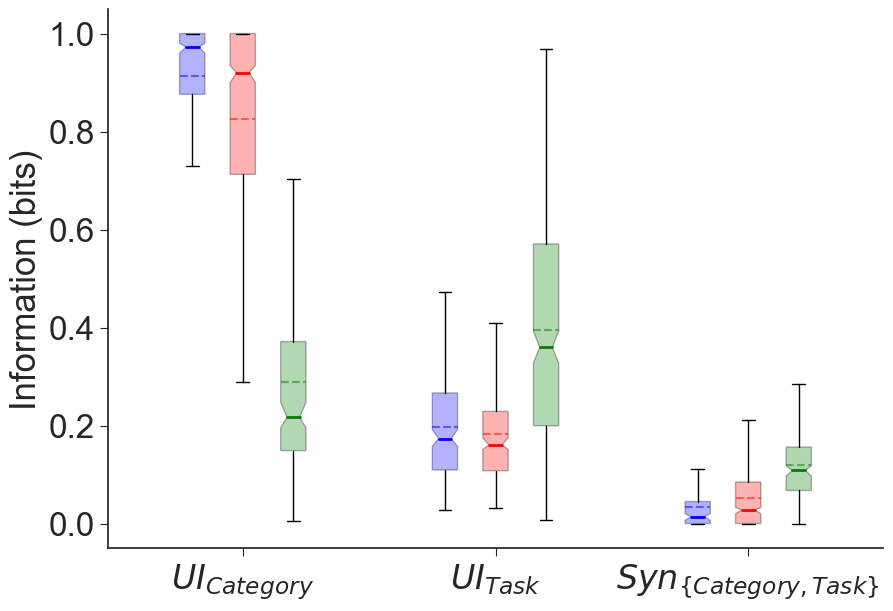

In [1075]:
plt.figure(figsize=(10,7))


colors=['blue','red','green']
def set_color(bplot) :
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.3)

    for median, color in zip(bplot['medians'], colors):
        median.set_color(color)
        median.set_linewidth(2)


    for mean, color in zip(bplot['means'], colors):
        mean.set_color(color)
        mean.set_alpha(0.5)
        mean.set_linewidth(1.5)


plt.ylim(-0.05,1.05)



bplot = plt.boxplot([MI_popA[0,:],MI_popB[0,:],MI_pop0[0,:]], positions=[0,0.3,0.6],\
                    patch_artist=True,notch=True,bootstrap=1000,sym='',showmeans=True,meanline=True)
set_color(bplot)


bplot = plt.boxplot([MI_popA[1,:],MI_popB[1,:],MI_pop0[1,:]], positions=[1.5,1.8,2.1],\
                    patch_artist=True,notch=True,bootstrap=1000,sym='',showmeans=True,meanline=True)
set_color(bplot)


bplot = plt.boxplot([MI_popA[2,:]-MI_popA[0,:],MI_popB[2,:]-MI_popB[0,:],MI_pop0[2,:]-MI_pop0[0,:]], positions=[3,3.3,3.6],\
                    patch_artist=True,notch=True,bootstrap=1000,sym='',showmeans=True,meanline=True)
set_color(bplot)

plt.xticks([0.3,1.8,3.3],[r'$UI_{Category}$',r'$UI_{Task}$',r'$Syn_{\{Category,Task\}}$'])
plt.ylabel('Information (bits)')
plt.yticks([0,0.2,0.4,0.6,0.8,1])


plt.savefig('Plots/SVG/MI_pop.SVG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/MI_pop.PNG', dpi = 300,bbox_inches='tight')

In [1074]:
from scipy.stats import mannwhitneyu

print('------- UI category -------')
print('A-B : ' + str(mannwhitneyu(MI_popA[0,:],MI_popB[0,:])))
print('A-0 : ' + str(mannwhitneyu(MI_popA[0,:],MI_pop0[0,:])))
print('B-0 : ' + str(mannwhitneyu(MI_popB[0,:],MI_pop0[0,:])))

print('------- UI task -------')
print('A-B : ' + str(mannwhitneyu(MI_popA[1,:],MI_popB[1,:])))
print('A-0 : ' + str(mannwhitneyu(MI_popA[1,:],MI_pop0[1,:])))
print('B-0 : ' + str(mannwhitneyu(MI_popB[1,:],MI_pop0[1,:])))

print('------- Synergy -------')
print('A-B : ' + str(mannwhitneyu(MI_popA[2,:]-MI_popA[0,:],MI_popB[2,:]-MI_popB[0,:])))
print('A-0 : ' + str(mannwhitneyu(MI_popA[2,:]-MI_popA[0,:],MI_pop0[2,:]-MI_pop0[0,:])))
print('B-0 : ' + str(mannwhitneyu(MI_popB[2,:]-MI_popB[0,:],MI_pop0[2,:]-MI_pop0[0,:])))

------- UI category -------
A-B : MannwhitneyuResult(statistic=56879.0, pvalue=2.2097556167894693e-05)
A-0 : MannwhitneyuResult(statistic=82191.5, pvalue=2.67795515923215e-87)
B-0 : MannwhitneyuResult(statistic=81291.0, pvalue=2.965364386432362e-76)
------- UI task -------
A-B : MannwhitneyuResult(statistic=51341.0, pvalue=0.08937714284673522)
A-0 : MannwhitneyuResult(statistic=20529.0, pvalue=8.440992002661087e-27)
B-0 : MannwhitneyuResult(statistic=18760.0, pvalue=1.8677017539577144e-32)
------- Synergy -------
A-B : MannwhitneyuResult(statistic=38038.0, pvalue=1.3684618061699198e-05)
A-0 : MannwhitneyuResult(statistic=10754.0, pvalue=9.523299604516385e-55)
B-0 : MannwhitneyuResult(statistic=18215.5, pvalue=7.042428642193541e-34)


#### Information according to task selectivity

In [829]:
def compute_UI_SYN(S_grid,IO_grid) :
    MI_AC_task = []
    MI_AS_task = []
    MI_AC_S_task = []
    for i in tqdm(range(len(S_grid))) :
        S = S_grid[i].T
        A_data = np.squeeze(IO_grid[i])
        
        s_data = np.array(stim)
        c_data = np.array(context)
        pC = np.array([0.5,0.5])
        pS = np.array([0.5,0.5])
        
        x_indices = np.array([(k+0.5)/5 for k in range(-5,5)])
        
        c_tuning = S[0,:]
        
        task_slices = [(c_tuning >= k/5)&(c_tuning <= (k+1)/5) for k in range(-5,5)]
        slices_numbers = np.array([np.sum(sli) for sli in task_slices])
    
        A_matrices = np.array([compute_prob(A_data[:,n]) for n in range(np.shape(A_data)[1])])
        AS_matrices = np.array([[compute_prob(A_data[s_data==-1,n]),compute_prob(A_data[s_data==1,n])] for n in range(np.shape(A_data)[1])])
        AC_matrices = np.array([[compute_prob(A_data[c_data==-1,n]),compute_prob(A_data[c_data==1,n])] for n in range(np.shape(A_data)[1])])
        
        ACS_matrices = np.array([[[compute_prob(A_data[(s_data==-1)&(c_data==-1),n]),compute_prob(A_data[(s_data==1)&(c_data==-1),n])],\
                             [compute_prob(A_data[(s_data==-1)&(c_data==1),n]),compute_prob(A_data[(s_data==1)&(c_data==1),n])]] for n in range(np.shape(A_data)[1])])
    
        MI_AS_s = []
        MI_AC_s = []
        MI_AC_S_s = []
        for n in range(np.shape(A_matrices)[0]) :
            pA = A_matrices[n]
            AS_mat = AS_matrices[n]
            AC_mat = AC_matrices[n]
            ACS_mat = ACS_matrices[n]
            
            MI_AS_s.append(MI(AS_mat,pA,pS))
            MI_AC_s.append(MI(AC_mat,pA,pC))
            MI_AC_S_s.append(cond_MI(ACS_mat,AS_mat,pA,pC,pS))
    
        
        MI_AS_s = np.array(MI_AS_s)
        MI_AC_s = np.array(MI_AC_s)
        MI_AC_S_s = np.array(MI_AC_S_s)


        MI_AC_task.append([np.mean(MI_AC_s[slice]) for slice in task_slices])
        MI_AS_task.append([np.mean(MI_AS_s[slice]) for slice in task_slices])
        MI_AC_S_task.append([np.mean(MI_AC_S_s[slice]) for slice in task_slices])

    return np.array([MI_AC_task, MI_AS_task, MI_AC_S_task])

In [871]:
grid_config4 = {"Lambda":3, "Noise":5 ,"Modulation std":1, \
               "Context":[2], "Stim":[1], "Modulation mean":np.linspace(-3,3,9)}


all_MIs_task = []
for k in range(11) :
    IO_grid4,_,_ = grid_search(grid_config4)
    S_s4 = np.squeeze(fit_grid(IO_grid4))
    MIs = compute_UI_SYN(S_s4,IO_grid4)
    all_MIs_task.append(MIs)

all_MIs_task = np.array(all_MIs_task)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

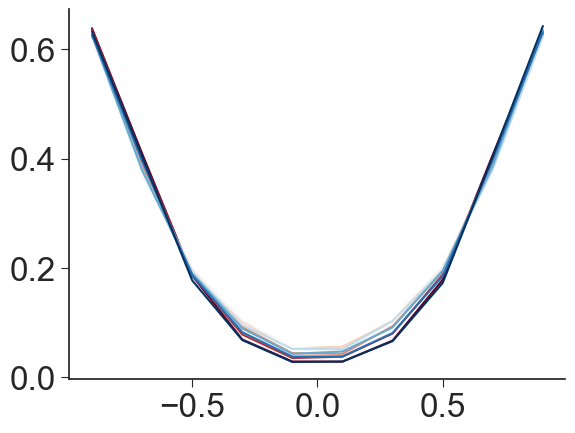

In [878]:
import matplotlib as mpl

cmap = mpl.colormaps['RdBu'](np.linspace(0,1,len(grid_config4['Modulation mean'])))

x_indices = np.array([(k+0.5)/5 for k in range(-5,5)])

for m in range(np.shape(all_MIs_task)[2]) : 
    plt.plot(x_indices,np.mean(all_MIs_task[:,0,m,:],axis=0), color=cmap[m])

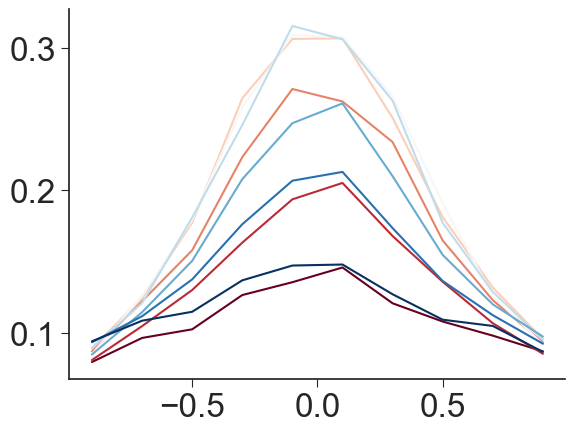

In [875]:
for m in range(np.shape(all_MIs_task)[2]) : 
    plt.plot(x_indices,np.mean(all_MIs_task[:,1,m,:],axis=0), color=cmap[m])

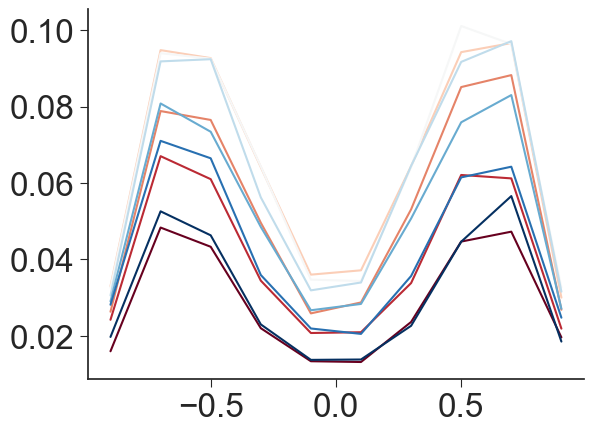

In [876]:
for m in range(np.shape(all_MIs_task)[2]) : 
    plt.plot(x_indices,np.mean(all_MIs_task[:,2,m,:],axis=0)-np.mean(all_MIs_task[:,0,m,:],axis=0), \
             color=cmap[m])
